# Do not change imports

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_similarity

from urllib.parse import urljoin
import itertools
import random

import matplotlib.pyplot as plt
%matplotlib inline

# A. MovieLens 100K Dataset: EDA via Pandas
Read the README (https://grouplens.org/datasets/movielens/100k/)

In [2]:
ML_100k_BASE_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/'

def movielens_url(fname):
    return urljoin(ML_100k_BASE_URL, fname)

## A.1. Read Genres

In [3]:
# names of the columns - see README, u.genre
genre_cols = ['genre', 'genre_id']

genres = pd.read_csv(movielens_url('u.genre'), sep='|', names=genre_cols)

genres

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


## A.2. Read Users

In [4]:
user_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

# read users from u.user
users = pd.read_csv(movielens_url('u.user'), sep='|', names=user_cols)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
user_id       943 non-null int64
age           943 non-null int64
sex           943 non-null object
occupation    943 non-null object
zip_code      943 non-null object
dtypes: int64(2), object(3)
memory usage: 36.9+ KB


## A.3. Read Movies

In [5]:
# Be lazy - let the genre table tell you the last set of column names
movie_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL'] + [g for g in genres.sort_values(by='genre_id')['genre']]
print(movie_cols)
# read movies from u.item
movies = pd.read_csv(movielens_url('u.item'), sep='|', names=movie_cols, encoding='latin-1')

movies.info()

['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
movie_id              1682 non-null int64
movie_title           1682 non-null object
release_date          1681 non-null object
video_release_date    0 non-null float64
IMDb_URL              1679 non-null object
unknown               1682 non-null int64
Action                1682 non-null int64
Adventure             1682 non-null int64
Animation             1682 non-null int64
Children's            1682 non-null int64
Comedy                1682 non-null int64
Crime                 1682 non-null int64
Documentary           1682 non-null int64
Drama                 1682 non-null int64
Fantasy       

In [6]:
# Interesting... find the row with a null release_date!
movies.index[pd.isnull(movies['release_date'])][0]

266

In [7]:
# assign movie_id (to check/clean up ratings later)
bad_row_id = 267

# drop the row (in place!)
movies.drop(movies.loc[pd.isnull(movies.release_date)].index, inplace=True)

# confirm it's gone
movies.index[pd.isnull(movies['release_date'])]

Int64Index([], dtype='int64')

In [8]:
# output a table including only the movies with null IMDB urls
movies.index[pd.isnull(movies['IMDb_URL'])]

Int64Index([1357, 1358], dtype='int64')

In [9]:
# output all the fields of the first row
movies.loc[1357]

movie_id                                1358
movie_title           The Deadly Cure (1996)
release_date                     16-Sep-1996
video_release_date                       NaN
IMDb_URL                                 NaN
unknown                                    0
Action                                     1
Adventure                                  0
Animation                                  0
Children's                                 0
Comedy                                     0
Crime                                      0
Documentary                                0
Drama                                      0
Fantasy                                    0
Film-Noir                                  0
Horror                                     0
Musical                                    0
Mystery                                    0
Romance                                    0
Sci-Fi                                     0
Thriller                                   0
War       

Try finding this movie with Google (it does exist) - what is special/different about it?
Answer: It's a TV series

In [10]:
# output all the fields of the second row
movies.loc[1358]

movie_id                               1359
movie_title           Boys in Venice (1996)
release_date                    24-Sep-1996
video_release_date                      NaN
IMDb_URL                                NaN
unknown                                   0
Action                                    0
Adventure                                 0
Animation                                 0
Children's                                0
Comedy                                    0
Crime                                     0
Documentary                               0
Drama                                     1
Fantasy                                   0
Film-Noir                                 0
Horror                                    0
Musical                                   0
Mystery                                   0
Romance                                   0
Sci-Fi                                    0
Thriller                                  0
War                             

Try finding this movie with Google - comment on the likely name/origin of this movie
Answer: According to IMDB, it's either The Boys of Venice (1978) or Boys in Love (1996)

In [11]:
# there is one movie with an unknown genre - what is it?
movies.index[movies['unknown'] == 1][0]

1372

Find this movie using Google - what is special about it? what would you indicate as its genre?
Answer: The genre should be comedy

In [12]:
# there is a field of the movies dataset that has no useful values - what is it?
bad_field = 'video_release_date'
movies.drop(bad_field, 1, inplace=True)

# It also turns out that the IMDB url's don't work :(
movies.drop('IMDb_URL', 1, inplace=True)

movies.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## A.4. Read Ratings

In [13]:
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

# read ratings from u.data
ratings = pd.read_csv(movielens_url('u.data'), sep='\t', names=rating_cols, encoding='latin-1')

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id           100000 non-null int64
movie_id          100000 non-null int64
rating            100000 non-null int64
unix_timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


In [14]:
# remember to drop ratings of our bad movie above
ratings.drop(ratings[ratings.movie_id == bad_row_id].index, inplace=True)

# confirm they are gone
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99991 entries, 0 to 99999
Data columns (total 4 columns):
user_id           99991 non-null int64
movie_id          99991 non-null int64
rating            99991 non-null int64
unix_timestamp    99991 non-null int64
dtypes: int64(4)
memory usage: 3.8 MB


# A.5. Merge Dataset

In [15]:
lens = pd.merge(pd.merge(movies, ratings), users)
lens.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Thriller,War,Western,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,0,0,0,0,1,1,0,...,0,0,0,308,5,887736696,60,M,retired,95076


## A.6. Ask Interesting Questions

In [16]:
# compute sparsity = 100% * (# ratings) / ((# users) * (# movies))
#       basically: what percentage of the full utility matrix is represented?
sparsity = len(lens.index) / (len(lens.groupby('user_id')) * len(lens.groupby('movie_id')))
print("Sparsity: {0:.2f}%".format(sparsity * 100))

Sparsity: 6.31%


In [17]:
# Aggregate by movie_id, get stats on number (i.e. size) of ratings per movie
lens.groupby('movie_id').agg({'rating' : 'size'}).describe()

,rating
count,1681.000000
mean,59.483046
std,80.398338
min,1.000000
25%,6.000000
50%,27.000000
75%,80.000000
max,583.000000


(array([  1.14500000e+03,   2.49000000e+02,   1.39000000e+02,
          6.70000000e+01,   3.80000000e+01,   2.40000000e+01,
          7.00000000e+00,   5.00000000e+00,   6.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   59.2,  117.4,  175.6,  233.8,  292. ,  350.2,  408.4,
         466.6,  524.8,  583. ]),
 <a list of 10 Patch objects>)

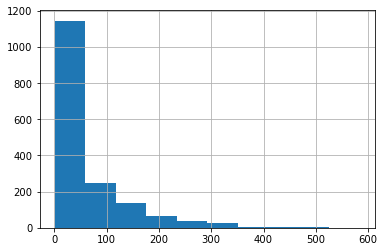

In [18]:
# Visualize the movie counts as a histogram
ratings_per_movie = lens.groupby('movie_id').size()
plt.grid(True)
plt.hist(ratings_per_movie)

In [19]:
# Aggregate by user_id, get stats on number (i.e. size) of ratings per user
lens.groupby('user_id').agg({'rating' : 'size'}).describe()

,rating
count,943.000000
mean,106.034995
std,100.920992
min,20.000000
25%,33.000000
50%,65.000000
75%,148.000000
max,737.000000


(array([ 560.,  183.,   96.,   55.,   25.,   15.,    5.,    1.,    1.,    2.]),
 array([  20. ,   91.7,  163.4,  235.1,  306.8,  378.5,  450.2,  521.9,
         593.6,  665.3,  737. ]),
 <a list of 10 Patch objects>)

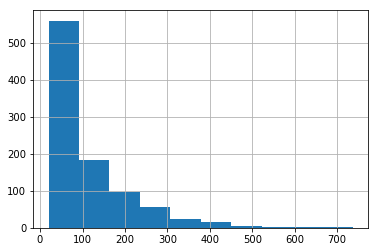

In [20]:
# Visualize the user counts as a histogram
ratings_per_user = lens.groupby('user_id').size()
plt.grid(True)
plt.hist(ratings_per_user)

comment on the last two stats tables/plots - what does this say in general about ratings per user/movie?

Answer: Higher average of ratings per user in comparison to ratings per movie

In [21]:
# Which movie has the most ratings?
stats = lens.groupby("movie_id").agg({'rating' : 'size'}).to_dict()['rating']
max_rating_movie_id = max(stats, key=stats.get)
movies.loc[movies['movie_id'] == max_rating_movie_id]

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
49,50,Star Wars (1977),01-Jan-1977,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


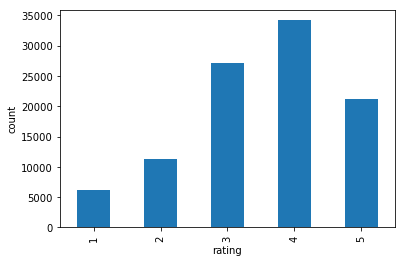

In [22]:
# are all ratings equally likely? output a bar chart of rating frequency overall
ratings_bar = lens['rating']
p = ratings_bar.value_counts().sort_index().plot(kind = "bar")
p.set_xlabel("rating")
p.set_ylabel("count")

In [23]:
# of the movies that have 300 or more ratings, what are the top-ten ranked movies?
size_and_mean = lens.groupby(["movie_id", 'movie_title']).agg({'rating' : ['size', 'mean']})
qualified_size_and_mean = size_and_mean.loc[size_and_mean['rating']['size'] >= 300]
qualified_size_and_mean['rating'].sort_values(by=['mean'], ascending=False).head(10)

,,size,mean
movie_id,movie_title,,
50,Star Wars (1977),583,4.358491
98,"Silence of the Lambs, The (1991)",390,4.289744
127,"Godfather, The (1972)",413,4.283293
174,Raiders of the Lost Ark (1981),420,4.252381
313,Titanic (1997),350,4.245714
172,"Empire Strikes Back, The (1980)",367,4.204360
173,"Princess Bride, The (1987)",324,4.172840
100,Fargo (1996),508,4.155512
168,Monty Python and the Holy Grail (1974),316,4.066456


In [24]:
# describe one more interesting question, and then query the result with Pandas
# The top 10 rating movies by gender
lens.pivot_table('rating', index='movie_title', columns='sex', aggfunc='mean').sort_values(by='F', ascending=False).head(10)

sex,F,M
movie_title,,
Someone Else's America (1995),5.0,NaN
Maya Lin: A Strong Clear Vision (1994),5.0,4.333333
Foreign Correspondent (1940),5.0,3.785714
Faster Pussycat! Kill! Kill! (1965),5.0,2.666667
Telling Lies in America (1997),5.0,3.083333
Prefontaine (1997),5.0,5.000000
Everest (1998),5.0,4.000000
Stripes (1981),5.0,3.500000
"Visitors, The (Visiteurs, Les) (1993)",5.0,2.000000


# B. Extract Utility Matrix

In [25]:
def user_id_to_index(id):
    return id-1

def user_index_to_id(idx):
    return idx+1

# Accounts for the bad movie
def movie_id_to_index(id):
    return id-1 if id<bad_row_id else id-2

# Accounts for the bad movie
def movie_index_to_id(idx):
    return idx+1 if idx<(bad_row_id-1) else idx+2

In [26]:
num_users = ratings.user_id.unique().shape[0]
num_movies = ratings.movie_id.unique().shape[0]

utility = np.zeros((num_users, num_movies))

for idx,rating in ratings.iterrows():
    utility[user_id_to_index(rating.user_id), movie_id_to_index(rating.movie_id)] = rating.rating

# should match above!
sparsity = float(len(utility.nonzero()[0]))
sparsity /= (utility.shape[0] * utility.shape[1])
sparsity *= 100
print('Sparsity: {:.2f}%'.format(sparsity))

Sparsity: 6.31%


# C. Evaluation via Mean Squared Error (MSE)

In [27]:
a = [1, 2, 3, 4, 5]
b = [1, 1, 4, 2, 10]
print("{:.4f}".format(mse(a, b)))

6.2000


Show the mathematical operations that reproduce the above result

$$ mse = (a-b) \cdot (a-b) / (1 * 5) $$
$$ mse = 31 / 5 $$
$$ mse = 6.2 $$

In [28]:
def mse_utility(u1, u2):
    return mse(u1[u1.nonzero()].flatten(), u2[u2.nonzero()].flatten())

u1 = np.array([[2, 0, 0, 4, 4], [5, 5, 5, 3, 3], [2, 4, 2, 1, 2]])
u2 = np.array([[3, 0, 0, 4, 4], [5, 5, 5, 3, 3], [2, 4, 2, 1, 7]])

print("{:.4f}".format(mse_utility(u1, u2)))

2.0000


TODO: 
1. Explain what operation is being performed. Include *why* it is appropriate in the context evaluating a recommender system, as well as performance implications.

2. Show the mathematical operations that reproduce the above result

$$ mse = \ldots $$

# D. Similarity via Cosine Distance

In [29]:
# Implement, only use primitive Python loops/operations
# sim = (A . B) / ( ||A|| ||B|| )
def cosine_sim(v1, v2):
    numerator = sum([x * y for x, y in zip(v1, v2)])
    denominator = np.sqrt(sum([x ** 2 for x in v1])) * np.sqrt(sum([x ** 2 for x in v2]))
    return numerator / denominator
    
v1 = [5, 0, 3, 0, 2, 0, 0, 2, 0, 0]
v2 = [3, 0, 2, 0, 1, 1, 0, 1, 0, 1]

print("Cosine Similarity: {:.6f}, expected={:.6f}".format(cosine_sim(v1, v2), cosine_similarity(np.array(v1).reshape(1, -1), np.array(v2).reshape(1, -1))[0][0]))

Cosine Similarity: 0.935601, expected=0.935601


In [30]:
def sim_matrix(u, eps=1.0e-9):
    step1 = u.dot(u.T) + eps
    step2 = np.array([np.sqrt(np.diagonal(step1))])
    return (step1 / step2 / step2.T)

print(sim_matrix(u1))
print(cosine_sim(u1[0], u1[1]))
print(cosine_sim(u1[0], u1[2]))
print(cosine_sim(u1[1], u1[2]))

[[ 1.          0.58760596  0.49518757]
 [ 0.58760596  1.          0.94352977]
 [ 0.49518757  0.94352977  1.        ]]
0.587605960347
0.495187568472
0.943529768569


In [31]:
def sim_allpairs(u):
    n = u.shape[0]
    sim = np.eye(n)
    for x in itertools.combinations(range(n), 2):
        s = cosine_sim(u[x[0]], u[x[1]])
        sim[x[0], x[1]] = s
        sim[x[1], x[0]] = s
    
    return sim

print("MSE for U1: {:.4f}".format(mse_utility(sim_matrix(u1), sim_allpairs(u1))))
print("MSE for U2: {:.4f}".format(mse_utility(sim_matrix(u2), sim_allpairs(u2))))

MSE for U1: 0.0000
MSE for U2: 0.0000


In [32]:
%timeit -n 10 -r 3 sim_matrix(utility[:50,:])

10 loops, best of 3: 309 µs per loop


In [33]:
%timeit -n 10 -r 3 sim_allpairs(utility[:50,:])

10 loops, best of 3: 1.76 s per loop


TODO:
1. Explain what each line of sim_matrix is doing (including why eps is necessary)

Answer: step1 use a matrix times its transform, step2 find the norm of the matrix. eps is Necesary in case when the denominator is 0

2. Explain why this approach is preferable to pairwise calls to cosine_sim (reference the previous two timeit calls; explain what each is doing and how it relates to your conclusion)

Answer: The complexity for the first one is $n^2$, while second one is $n^3$

In [34]:
def sim_users(u):
    return sim_matrix(u)

# use sim_matrix to return similarity between items (i.e. movies)
def sim_items(u):
    return sim_matrix(u.T)

print(sim_items(u1))
print(cosine_sim(u1[:, 0], u1[:, 1]))
print(cosine_sim(u1[:, 0], u1[:, 2]))
print(cosine_sim(u1[:, 0], u1[:, 3]))
print(cosine_sim(u1[:, 0], u1[:, 4]))
print(cosine_sim(u1[:, 1], u1[:, 2]))
print(cosine_sim(u1[:, 1], u1[:, 3]))
print(cosine_sim(u1[:, 1], u1[:, 4]))
print(cosine_sim(u1[:, 2], u1[:, 3]))
print(cosine_sim(u1[:, 2], u1[:, 4]))
print(cosine_sim(u1[:, 3], u1[:, 4]))

[[ 1.          0.89714996  0.93743687  0.85348593  0.87278605]
 [ 0.89714996  1.          0.9570244   0.5819357   0.66701701]
 [ 0.93743687  0.9570244   1.          0.61910348  0.65517241]
 [ 0.85348593  0.5819357   0.61910348  1.          0.983282  ]
 [ 0.87278605  0.66701701  0.65517241  0.983282    1.        ]]
0.897149958915
0.937436866561
0.853485927499
0.872786048178
0.957024404433
0.58193569724
0.667017009151
0.61910348462
0.655172413793
0.983282004984


# E. K-Neighborhood

In [35]:
# TODO: given a slice from a similarity matrix (arr),
#       index of "self" (self_idx),
#       and k
#       return dictionary of k most similar indexes as {idx:sim}
#       HINT: look at np.argsort
def top_k(arr, self_idx, k):
    val_index = { v:key for key, v in enumerate(arr) }
    top_k_val = sorted(val_index.keys())[::-1]
    i = 0
    res = {}
    while i < k:
        if val_index[top_k_val[i]] == self_idx:
            i += 1
            k += 1
            continue
        res[val_index[top_k_val[i]]] = top_k_val[i]
        i += 1
    return res

In [36]:
sim_u1 = sim_items(u1)

# Example via u1...
print(sim_u1)
print()

# Top-2 w.r.t. row 0 (should be {1: 0.897, 2:0.937})
print(sim_u1[0])
print(top_k(sim_u1[0], 0, 2))
print()

# Top-2 w.r.t. row 1 (should be {0: 0.897, 2:0.957})
print(sim_u1[1])
print(top_k(sim_u1[1], 1, 2))
print()

# Top-3 w.r.t. col 1 (should be {0: 0.897, 2:0.957, 4:0.667})
print(sim_u1[:, 1])
print(top_k(sim_u1[:, 1], 1, 3))
print()

[[ 1.          0.89714996  0.93743687  0.85348593  0.87278605]
 [ 0.89714996  1.          0.9570244   0.5819357   0.66701701]
 [ 0.93743687  0.9570244   1.          0.61910348  0.65517241]
 [ 0.85348593  0.5819357   0.61910348  1.          0.983282  ]
 [ 0.87278605  0.66701701  0.65517241  0.983282    1.        ]]

[ 1.          0.89714996  0.93743687  0.85348593  0.87278605]
{2: 0.93743686656305114, 1: 0.89714995891726312}

[ 0.89714996  1.          0.9570244   0.5819357   0.66701701]
{2: 0.95702440443430259, 0: 0.89714995891726301}

[ 0.89714996  1.          0.9570244   0.5819357   0.66701701]
{2: 0.9570244044343027, 0: 0.89714995891726312, 4: 0.66701700915996875}



# F. Recommend via Similar Users

In [49]:
# given utility matrix (m_utility),
#       similarity of users (m_sim_users),
#       user index of interest (user_idx),
#       item index of interest (item_idx),
#       neighborhood size (k)
# 
#       output the average of the similarity-weighted ratings
#       of top-k similar users that have
#       rated the item
def rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k):
    items = m_utility[:, item_idx]
    i_sim = top_k(m_sim_users[:, user_idx], user_idx, k)
    non_zero_index = [i for i in i_sim if items[i] != 0]
    if sum([i_sim[i] for i in non_zero_index]) == 0:
        return 0
    return sum([i_sim[i] * items[i] for i in non_zero_index]) / sum([i_sim[i] for i in non_zero_index])
    
print(u1)
print()
print(sim_users(u1))
print()

# Expected: 5
print(rec_via_users(u1, sim_users(u1), 0, 1, 1))

# Expected: 4.54 ~ (.588 * 5) + (.495 * 4) / (.588 + .495)
print(rec_via_users(u1, sim_users(u1), 0, 1, 2))

[[2 0 0 4 4]
 [5 5 5 3 3]
 [2 4 2 1 2]]

[[ 1.          0.58760596  0.49518757]
 [ 0.58760596  1.          0.94352977]
 [ 0.49518757  0.94352977  1.        ]]

5.0
4.542675907


## F.1. Evaluation

In [50]:
random.seed(12345)

def recs_via_users(m_utility, m_sim_users, k, test_n):
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                
                p = round(rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
similarity_users = sim_users(utility)

ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_users(utility, similarity_users, i+1, 100))
    print("{}/50".format(i+1), mses[-1])

1/50 5.84233774793
2/50 3.87098117454
3/50 2.91131117606
4/50 2.39764980189
5/50 2.33668038893
6/50 2.29493339095
7/50 1.90007002056
8/50 1.70336661621
9/50 1.7880964089
10/50 1.61932981332
11/50 1.61931922692
12/50 1.56165359917
13/50 1.49226336547
14/50 1.51568283632
15/50 1.51010054401
16/50 1.51669524844
17/50 1.31786563335
18/50 1.26729492381
19/50 1.56933414766
20/50 1.35265504646
21/50 1.28939409727
22/50 1.41813828177
23/50 1.44438610293
24/50 1.32207736683
25/50 1.29565816667
26/50 1.23283129665
27/50 1.28004578392
28/50 1.15182829878
29/50 1.27704705434
30/50 1.26735144462
31/50 1.28266283514
32/50 1.28568822391
33/50 1.23708402271
34/50 1.34405290325
35/50 1.16755410505
36/50 1.15406826846
37/50 1.31856390908
38/50 1.15653345297
39/50 1.2239051695
40/50 1.08491307759
41/50 1.17474633587
42/50 1.23082191773
43/50 1.27174887883
44/50 1.37380497121
45/50 1.18467172372
46/50 1.16741391673
47/50 1.17197754402
48/50 1.09989130429
49/50 1.13677213996
50/50 1.24291620442


In [51]:
%timeit -n 10 -r 3 recs_via_users(utility, similarity_users, 2, 100)

10 loops, best of 3: 4.73 s per loop


In [52]:
%timeit -n 10 -r 3 recs_via_users(utility, similarity_users, 20, 100)

10 loops, best of 3: 4.83 s per loop


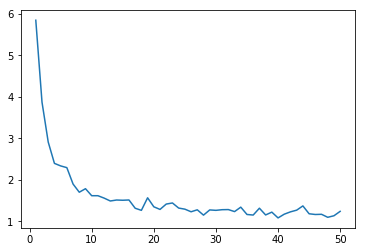

In [53]:
plt.plot(ks, mses)

TODO:
1. Describe what is being done in the recs_via_users function - what is the evaluation approach? What would have been a more "fair" methodology?
2. What do you notice happening as k increases?

Answer: stops decreasing much, converging

3. Based upon these results, what is a reasonable neighborhood size?

Answer: around 6

# G. Recommend via SVD

In [42]:
random.seed(12345)

# given a utility matrix and
#       number of singular values to use
# 
#       return a projected matrix
#       based upon a limited number of dimensions
#       U_pred = U S V^T
# 
#       HINT: the svds function does most of the work for you
def svd_projection(m_utility, num_dims):
    svd_u,svd_s,svd_vt = svds(m_utility, num_dims)
    return np.dot(svd_u, np.dot(np.diag(svd_s), svd_vt))

def recs_via_svd(m_utility, num_dims, test_n):
    test = random.sample(range(m_utility.shape[0]), test_n)    
    svd_utility = svd_projection(utility, num_dims)
    
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                p = round(svd_utility[user_idx][item_idx])
                
                if p != 0:
                    pred.append(p)
                else:
                    pred.append(1.0e-9)

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
    
ds = []
mses = []
for i in range(100):
    ds.append(i+1)
    mses.append(recs_via_svd(utility, i+1, 100))
    print("{}/100".format(i+1), mses[-1])

1/100 7.74736663055
2/100 6.61002831758
3/100 6.69830475868
4/100 5.93326157042
5/100 6.09860427627
6/100 6.38261629051
7/100 5.43443032806
8/100 5.36750021995
9/100 5.45322183861
10/100 5.43443594347
11/100 4.78831646654
12/100 5.36483046439
13/100 5.68029025621
14/100 4.89187609506
15/100 4.94779079348
16/100 5.26914153052
17/100 4.58554195573
18/100 5.01852645025
19/100 4.47604502941
20/100 4.92531414602
21/100 4.6113254764
22/100 4.62835478323
23/100 4.313030541
24/100 4.97499465627
25/100 4.28523432059
26/100 4.43876101104
27/100 4.31600534086
28/100 4.29014308361
29/100 4.37198962514
30/100 4.30171834438
31/100 4.0092911871
32/100 3.91744960262
33/100 4.14212171299
34/100 3.93378023311
35/100 3.94297492216
36/100 4.05826544235
37/100 3.7027260581
38/100 3.77045352439
39/100 4.06223246567
40/100 3.78134008865
41/100 3.90313069065
42/100 3.61386986253
43/100 3.66816143443
44/100 3.44324700108
45/100 3.61600836995
46/100 3.54949784749
47/100 3.49292322251
48/100 3.84586956471
49/100

In [43]:
%timeit -n 10 -r 3 recs_via_svd(utility, 10, 100)

10 loops, best of 3: 230 ms per loop


In [44]:
%timeit -n 10 -r 3 recs_via_svd(utility, 20, 100)

10 loops, best of 3: 310 ms per loop


In [45]:
%timeit -n 10 -r 3 recs_via_svd(utility, 40, 100)

10 loops, best of 3: 500 ms per loop


In [46]:
%timeit -n 10 -r 3 recs_via_svd(utility, 80, 100)

10 loops, best of 3: 803 ms per loop


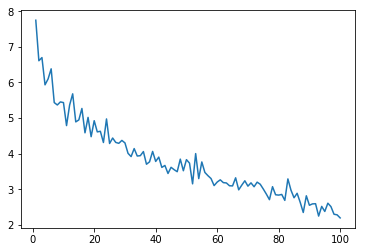

In [47]:
plt.plot(ds, mses)

comment on the relative speed/quality of the SVD approach as compared to the neighborhood approach

Answer: SVD is much faster and scales much better compared to the neighborhood approach as the SVD can approximate with gradient descent

# H. TODO: Your Turn
The previous sections explored some building blocks and methods of recommendation for the MovieLens dataset.
In this section, you must extend this work:
1. Implement a method that was not covered above (e.g. item-based neighborhood, direct matrix factorization) OR extend a method (e.g. incorporate rating bias)
2. Evaluate your method similar to what was done above

Do NOT change any code above - only add code/comment in this section (as many cells as you see fit). You are welcome to copy-paste code from above.

# I. Extra Credit
If you so choose, create an actual recommendation engine using one of the supplied methods:
1. Create a function that takes as input a dictionary of {movie_title:rating}, as well as a k, and your function should return the top k movies that have not been watched and have highest predicted ratings.
2. Run the function on a few representative examples - analyze your results.